# Experiments for Vehicle Detection and Tracking

This notebook is baiscally an exploratory workbook to play with the data and visualize it. The final computations are moved into two python scripts called `train_clf.py` to train the classifier and `detect_and_track.py` to annotate the video

## Read Data

Use the utility funcitons in helper/io to read the dataset. Basically this used a glob to load all .png images from supfolders and reads them.

In [3]:
from helper.io import read_data_set
from helper.feature_extrection import data_look
vehicle_files, non_vehicle_files = read_data_set("./data")
print(data_look(vehicle_files, non_vehicle_files))

{'n_cars': 8792, 'n_notcars': 8968, 'image_shape': (64, 64, 3), 'data_type': dtype('float32')}


## Feature visualization
Two features are used for later classification. For the report and for debugging it is nice to visualize them.

In [1]:
# choose a random vehicle and non-vehicle image:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

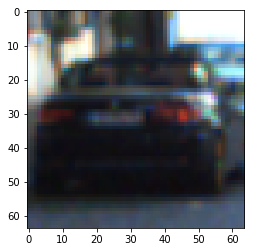

In [4]:
idx = random.randint(0, len(vehicle_files))
file = vehicle_files[idx]
vehicle = mpimg.imread(file)
plt.imshow(vehicle)

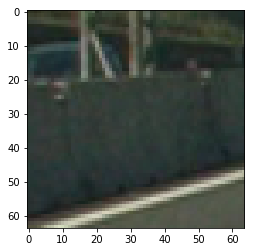

In [5]:
idx = random.randint(0, len(non_vehicle_files))
file = non_vehicle_files[idx]
non_vehicle = mpimg.imread(file)
plt.imshow(non_vehicle)

### Preprocessing
before computing the features we spacially fix each image to a resolution of 32x32 and convert the color space to HLS

In [6]:
import numpy as np
import cv2
vehicle_augmented = np.copy(vehicle)
vehicle_augmented = cv2.resize(vehicle_augmented, (32, 32))
vehicle_augmented = cv2.cvtColor(vehicle_augmented, cv2.COLOR_RGB2HLS)

non_vehicle_augmented = np.copy(non_vehicle)
non_vehicle_augmented = cv2.resize(non_vehicle_augmented, (32, 32))
non_vehicle_augmented = cv2.cvtColor(non_vehicle_augmented, cv2.COLOR_RGB2HLS)

### Color Histogram

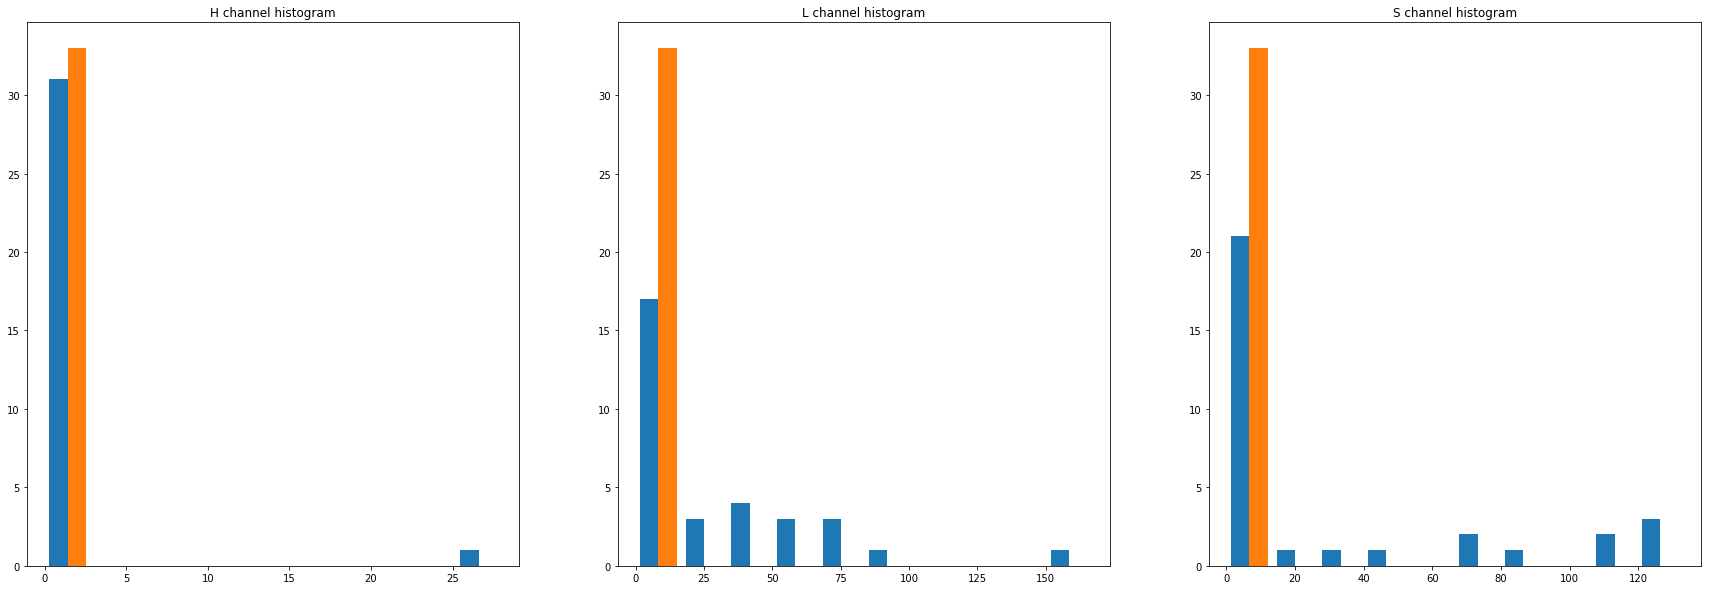

In [10]:
from helper.feature_extrection import color_hist

h_hist,l_hist,s_hist,centers,all_features = color_hist(vehicle_augmented, nbins=32, bins_range=(0,1))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
ax1.hist(h_hist)
ax1.set_title('H channel histogram')

ax2.hist(l_hist)
ax2.set_title('L channel histogram')

ax3.hist(s_hist)
ax3.set_title('S channel histogram')

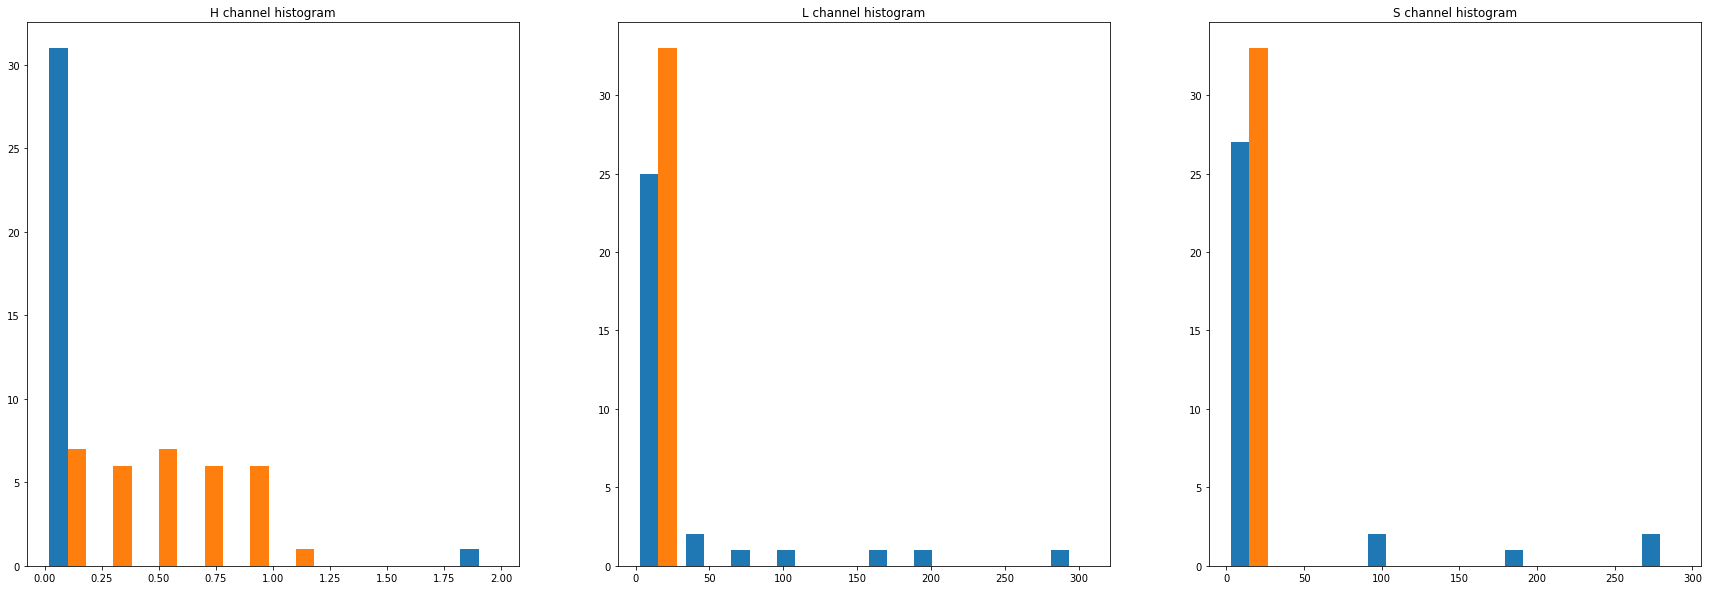

In [11]:
from helper.feature_extrection import color_hist

h_hist,l_hist,s_hist,centers,all_features = color_hist(non_vehicle_augmented, nbins=32, bins_range=(0,1))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
ax1.hist(h_hist)
ax1.set_title('H channel histogram')

ax2.hist(l_hist)
ax2.set_title('L channel histogram')

ax3.hist(s_hist)
ax3.set_title('S channel histogram')

### HOG Features

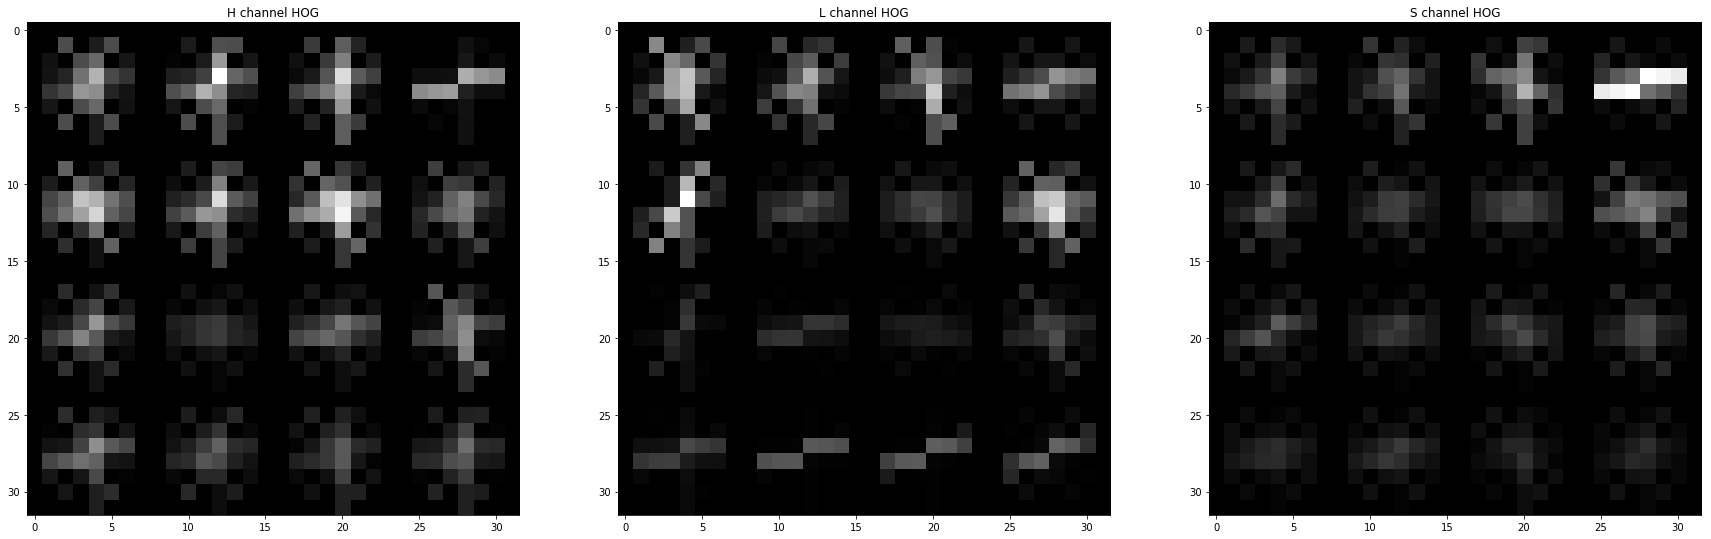

In [12]:
from helper.feature_extrection import get_hog_features
h_f, h_img = get_hog_features(vehicle_augmented[:,:,0], 9, 8, 1, vis=True, feature_vec=True)
l_f, l_img = get_hog_features(vehicle_augmented[:,:,1], 9, 8, 1, vis=True, feature_vec=True)
s_f, s_img = get_hog_features(vehicle_augmented[:,:,2], 9, 8, 1, vis=True, feature_vec=True)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
ax1.imshow(h_img, cmap='gray')
ax1.set_title('H channel HOG')

ax2.imshow(l_img, cmap='gray')
ax2.set_title('L channel HOG')

ax3.imshow(s_img, cmap='gray')
ax3.set_title('S channel HOG')

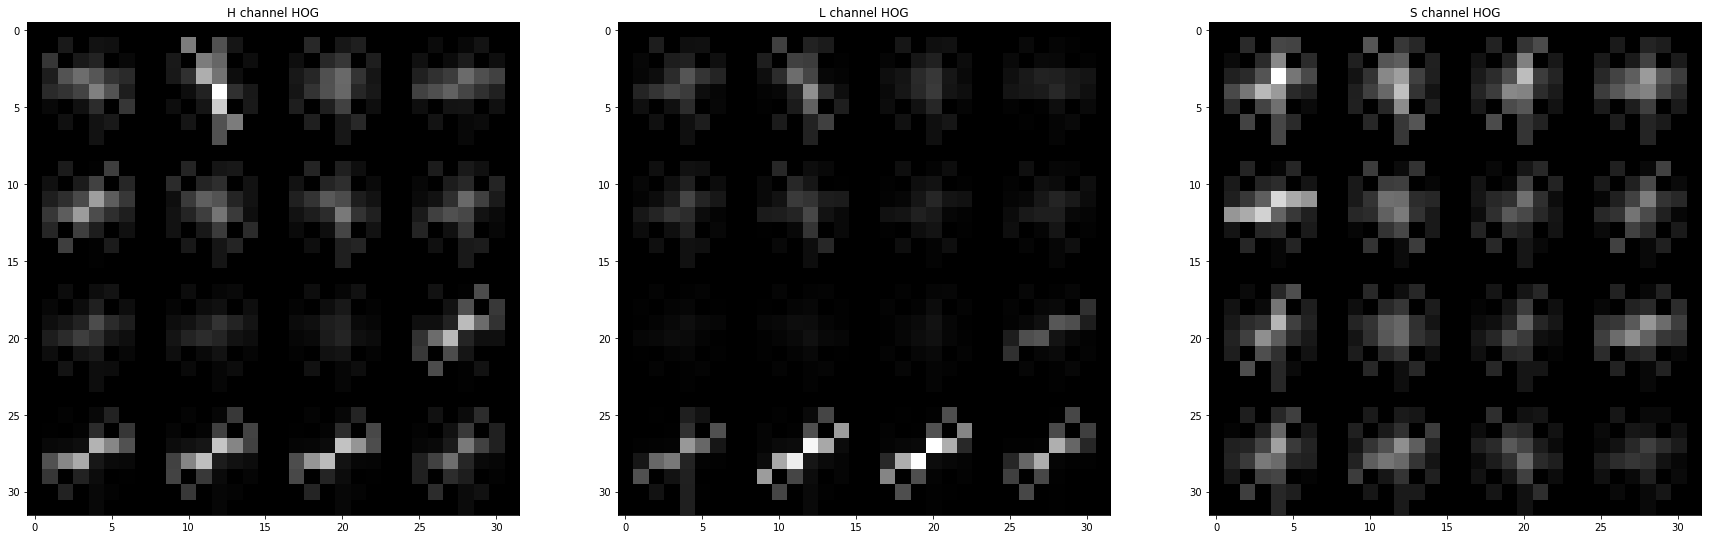

In [13]:
from helper.feature_extrection import get_hog_features
h_f, h_img = get_hog_features(non_vehicle_augmented[:,:,0], 9, 8, 1, vis=True, feature_vec=True)
l_f, l_img = get_hog_features(non_vehicle_augmented[:,:,1], 9, 8, 1, vis=True, feature_vec=True)
s_f, s_img = get_hog_features(non_vehicle_augmented[:,:,2], 9, 8, 1, vis=True, feature_vec=True)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
ax1.imshow(h_img, cmap='gray')
ax1.set_title('H channel HOG')

ax2.imshow(l_img, cmap='gray')
ax2.set_title('L channel HOG')

ax3.imshow(s_img, cmap='gray')
ax3.set_title('S channel HOG')

## Feature Extraction
now we have the paths to the dataset we must extract the features for each instance to get a vecture vector, and stack that in a veature matrix and a target vector

In [14]:
from helper.feature_extrection import extract_features

vehicle_features = extract_features(vehicle_files, cspace="HLS", use_spacial=False, hist_range=(0,1), cell_per_block=1)
non_vehicle_features = extract_features(non_vehicle_files, cspace="HLS", use_spacial=False, hist_range=(0,1), cell_per_block=1)

('convert img to color: ', 'HLS')
('num hist features: ', 96)
('hist describe: ', DescribeResult(nobs=96, minmax=(0.0, 0.248046875), mean=0.0625, variance=0.006345407586348684, skewness=0.9900791087517596, kurtosis=-0.5097607069851007))
('num hog features: ', 432)
('hog describe: ', DescribeResult(nobs=432, minmax=(0.0, 0.79858726665658175), mean=0.11099490810662109, variance=0.016294291464609454, skewness=2.66464872416733, kurtosis=8.883622552322668))
('convert img to color: ', 'HLS')
('num hist features: ', 96)
('hist describe: ', DescribeResult(nobs=96, minmax=(0.0, 1.31640625), mean=0.0625, variance=0.045653493780838814, skewness=4.688724299522603, kurtosis=22.08974318055931))
('num hog features: ', 432)
('hog describe: ', DescribeResult(nobs=432, minmax=(0.0, 0.59652856652042885), mean=0.10416167021466827, variance=0.0070605303004962119, skewness=1.8938332726413722, kurtosis=5.078619296453567))


In [15]:
print("vehicle_features shape:", vehicle_features[0].shape)

vehicle_features shape: (528,)


In [16]:
import numpy as np
from helper.classification import scale_features
X = np.vstack((vehicle_features + non_vehicle_features)).astype(np.float64)
scaled_X, X_scaler = scale_features(X)

y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

## Fit Model and test
now we have the features and the target vector, we can finally train our model. We split the sample into a 20% train, test split

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from helper.classification import scale_features, get_clf_candidates, fit_classifier

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

clfs = get_clf_candidates()
fit_all = fit_classifier(X_train, y_train, clfs)
for name, clf, score in fit_all:
    pred = clf.predict(X_test)
    print('test clf ', name)
    print('---------------------------------------')
    print(classification_report(y_test, pred))
    print('')
    print('---------------------------------------')
    print(confusion_matrix(y_test, pred))

svc[ovo]  has 0.993
svc  has 0.993
lin svc  has 0.972
lr  has 0.974
nn  has 0.906
lr(l1)  has 0.975
sgd[hinge]  has 0.964
decision tree  has 0.949
random forrest  has 0.971
ada boost  has 0.986
gradient boost  has 0.983
test clf  svc[ovo]
---------------------------------------
             precision    recall  f1-score   support

        0.0       1.00      0.99      1.00      1793
        1.0       0.99      1.00      1.00      1759

avg / total       1.00      1.00      1.00      3552


---------------------------------------
[[1781   12]
 [   5 1754]]
test clf  svc
---------------------------------------
             precision    recall  f1-score   support

        0.0       1.00      0.99      1.00      1793
        1.0       0.99      1.00      1.00      1759

avg / total       1.00      1.00      1.00      3552


---------------------------------------
[[1781   12]
 [   5 1754]]
test clf  lin svc
---------------------------------------
             precision    recall  f1-score 

In [19]:
# save the model to disk:
import pickle
with open('svc.p', 'wb') as f:
    pickle.dump(svc, f)
with open('scaler.p', 'wb') as f:
    pickle.dump(X_scaler, f)

# Sliding Window & Pipeline Experiments
This Notebook is basically a set of experiments for the real detection pipeline. Concretely it uses some test images to experiment and visualize with the sliding window computation strategy, and experiments for finding a suteable threshold for the headmap.

## Find slidning windows
We define sliding windows to search for cars. To not blow the computations we try to minimise the effort, but still have a good detection rate. Therefor we limit the search area to approx. the lower half of the image. Also do be less resolution dependent different sized sliding windows are used who then are all down or upsampled to the same size.

In [22]:
import matplotlib.image as mpimg
from helper.sliding_window import slide_window
image = mpimg.imread('test_images/test1.jpg')

layer1 = slide_window(image, y_start_stop=[380, None], xy_window=(192,192))
layer2 = slide_window(image, y_start_stop=[380, 650], xy_window=(128,128))
layer3 = slide_window(image, y_start_stop=[380, 650], xy_window=(96, 96))
layer4 = slide_window(image, y_start_stop=[380, 600], xy_window=(64,64))
all_layers = layer1 + layer2 + layer3 + layer4

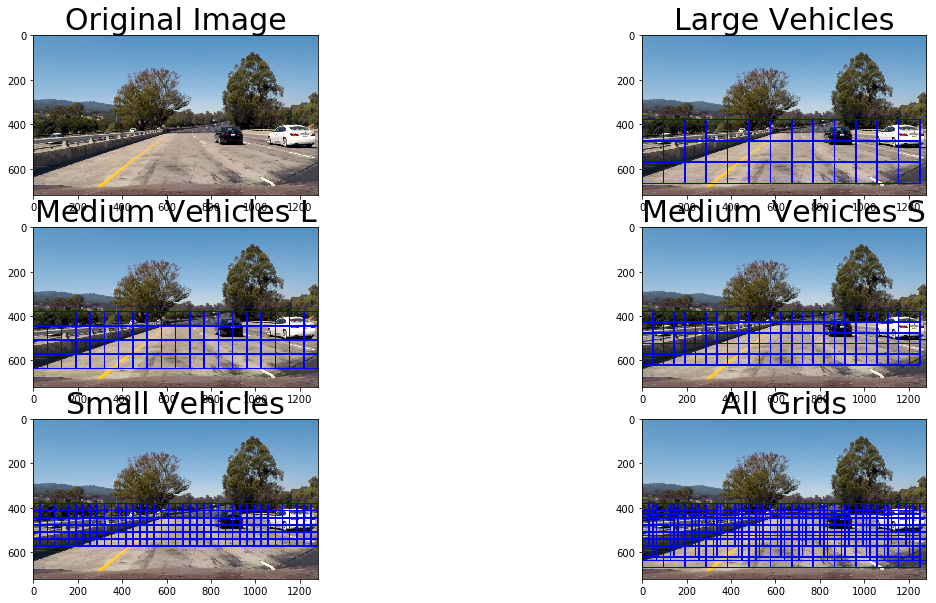

In [23]:
import matplotlib.pyplot as plt
from helper.draw import draw_boxes
%matplotlib inline

f, axarr = plt.subplots(3, 2, figsize=(20,10))

axarr[0, 0].imshow(image)
axarr[0, 0].set_title('Original Image', fontsize=30)

l1img = draw_boxes(image, layer1)
axarr[0, 1].imshow(l1img)
axarr[0, 1].set_title('Large Vehicles', fontsize=30)

l2img = draw_boxes(image, layer2)
axarr[1, 0].imshow(l2img)
axarr[1, 0].set_title('Medium Vehicles L', fontsize=30)

l3img = draw_boxes(image, layer3)
axarr[1, 1].imshow(l3img)
axarr[1, 1].set_title('Medium Vehicles S', fontsize=30)

l4img = draw_boxes(image, layer4)
axarr[2, 0].imshow(l4img)
axarr[2, 0].set_title('Small Vehicles', fontsize=30)

lall_img = draw_boxes(image, all_layers)
axarr[2, 1].imshow(lall_img)
axarr[2, 1].set_title('All Grids', fontsize=30)

set clf to:  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


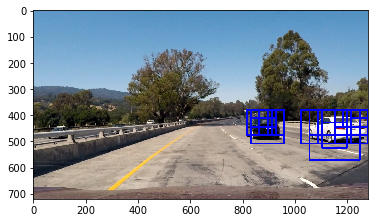

In [25]:
from helper.sliding_window import search_windows

clf_num = 0
print('set clf to: ', fit_all[clf_num][1])
clf = fit_all[clf_num][1]

found = search_windows(image, all_layers, clf, X_scaler, color_space="HLS", spatial_feat=False, hist_range=(0,256), cell_per_block=1)
test_img = draw_boxes(image, found)
plt.imshow(test_img)

## Show heatmap algorithm

In [66]:
from moviepy.editor import VideoFileClip

clip1 = VideoFileClip("./project_video.mp4", audio=False).subclip(t_start=29, t_end=29.25)
frames = []
for frame in clip1.iter_frames():
    frames.append(frame)
# we want 6, got 7, pop one:
frames = frames[:-1]

### Analyse classifier performance on 6 frames
having 6 frames gives us an interesting way to see the performance of the analyser. Show the found bounding boxes directly

set clf to:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


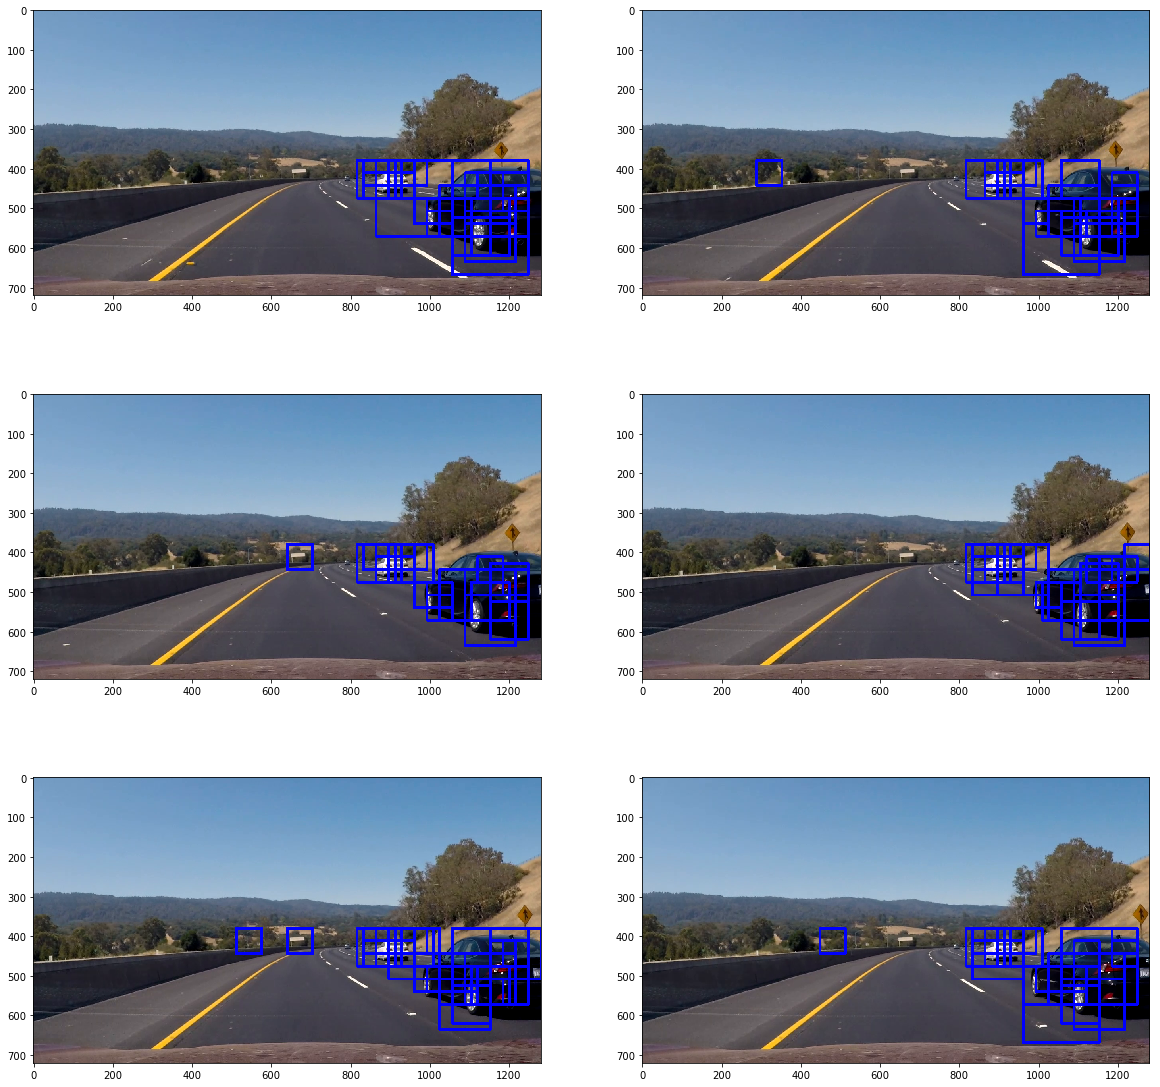

In [55]:
# clf_num = 4, seems the best currently, maybe also 5, 8, 10
clf_num = 8
print('set clf to: ', fit_all[clf_num][1])
clf = fit_all[clf_num][1]

f, axarr = plt.subplots(3, 2, figsize=(20,20))

for i in range(len(frames)):
    f = frames[i]
    found = search_windows(f, all_layers, clf, X_scaler, color_space="HLS", spatial_feat=False, hist_range=(0,256), cell_per_block=1)
    test_img = draw_boxes(f, found)
    axarr[i//2, i%2].imshow(test_img)

### Analyse Heatmap Algorithm

In [65]:
from collections import deque
heatmaps = deque([])

def search_windows_args(image, layers, clf, X_scaler):
    return search_windows(image, layers, clf, X_scaler, color_space="HLS", spatial_feat=False, hist_range=(0,256), cell_per_block=1)

def push_pop(heatmaps, heat):
    heatmaps.append(heat)
    if len(heatmaps) > 10:
        heatmaps.popleft()
    return heatmaps

def avarage_heat(heatmaps):
    h = list(heatmaps)
    if len(h) > 1:
        res = reduce(np.add, h)
        res = res/len(h)
    else:
        res = h[0]
    return res, len(h)

#### direct heatmap of each frame
the following cell shows the direct heatmap of each frame. There are less artefacts build up over time because there is no history, but on the other hand in frames 2,3,5,6 they are clearer visible than in the avaraged map

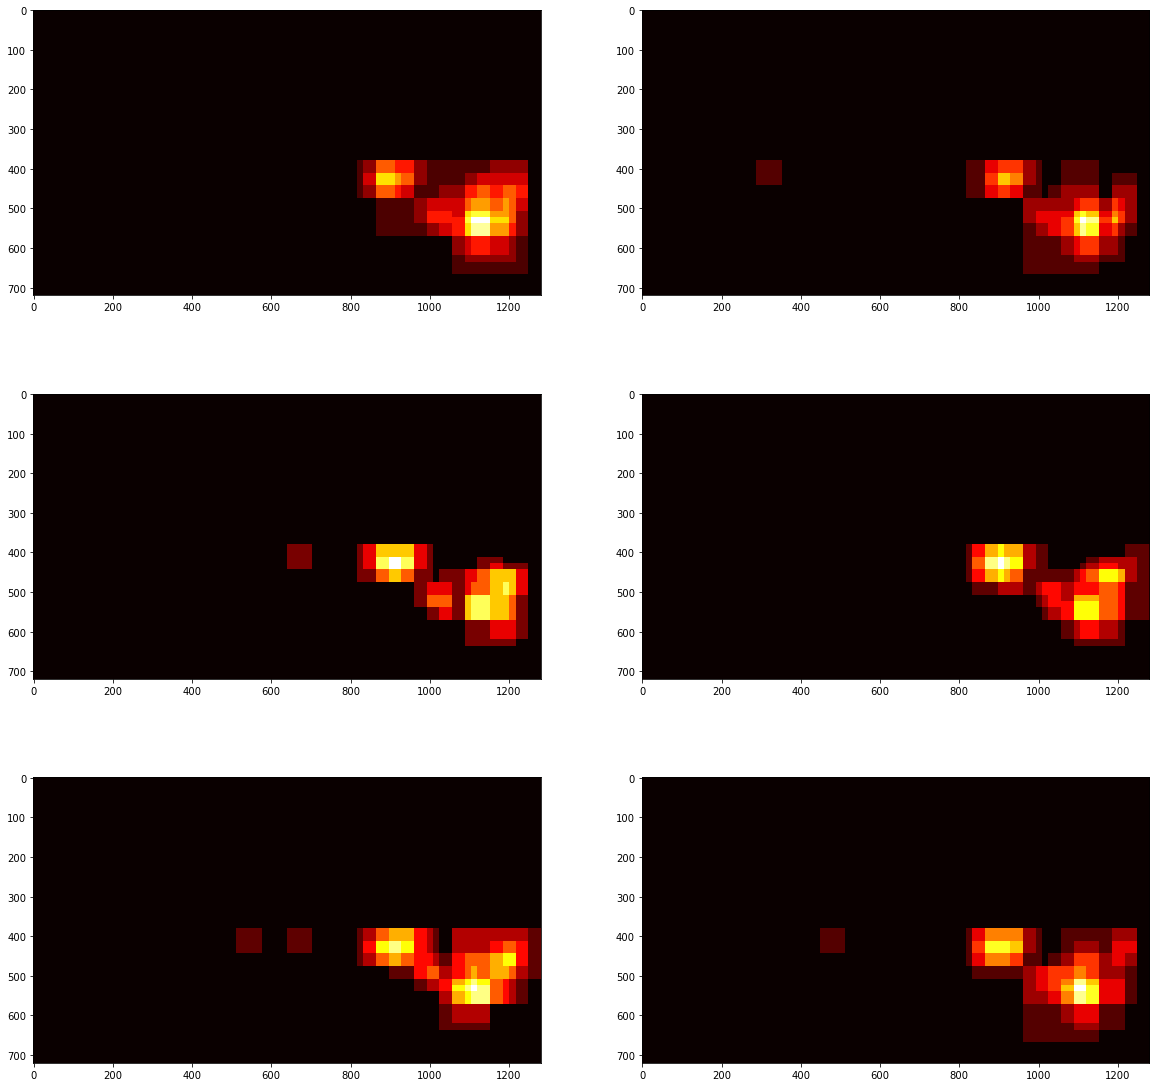

In [59]:
from helper.sliding_window import add_heat

f, axarr = plt.subplots(3, 2, figsize=(20,20))

for i in range(len(frames)):
    f = frames[i]
    heat = np.zeros_like(f[:, :, 0]).astype(np.float)
    found = search_windows(f, all_layers, clf, X_scaler, color_space="HLS", spatial_feat=False, hist_range=(0,256), cell_per_block=1)
    #draw_img = draw_boxes(np.copy(image), found)
    heat = add_heat(heat, found)
    axarr[i//2, i%2].imshow(heat, cmap='hot', interpolation='nearest')

#### heatmap avaraged over 10 (here max 6) frames
the following show how the avaraging builds up. Keeping all the frames means single artefacts persist in the memory, but the also have a very low weight when avaraged

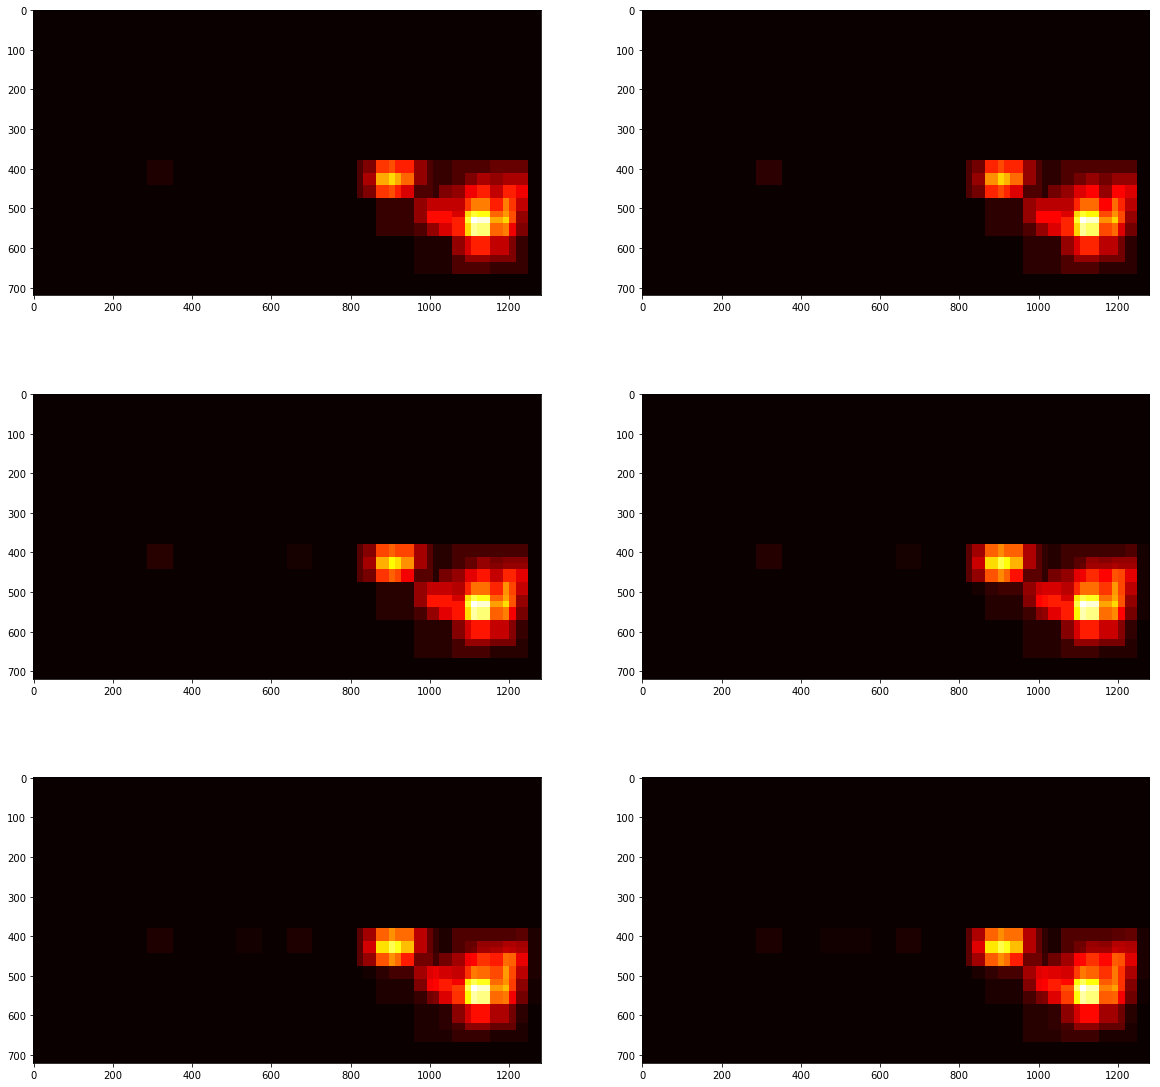

In [61]:
from functools import reduce

f, axarr = plt.subplots(3, 2, figsize=(20,20))

for i in range(len(frames)):
    f = frames[i]
    heat = np.zeros_like(f[:, :, 0]).astype(np.float)
    found = search_windows(f, all_layers, clf, X_scaler, color_space="HLS", spatial_feat=False, hist_range=(0,256), cell_per_block=1)
    #draw_img = draw_boxes(np.copy(image), found)
    heat = add_heat(heat, found)
    heatmaps = push_pop(heatmaps, heat)
    av_h, l = avarage_heat(heatmaps)
    axarr[i//2, i%2].imshow(av_h, cmap='hot', interpolation='nearest')

#### avaraged heatmap over time thresholded

the next step explores the effect of thresholding the heatmap. A threshold of 0.9 is used, as this already removed almost all of the noise in the example. 0.9 basically means that in 9 of 10 frames the area must be detected.

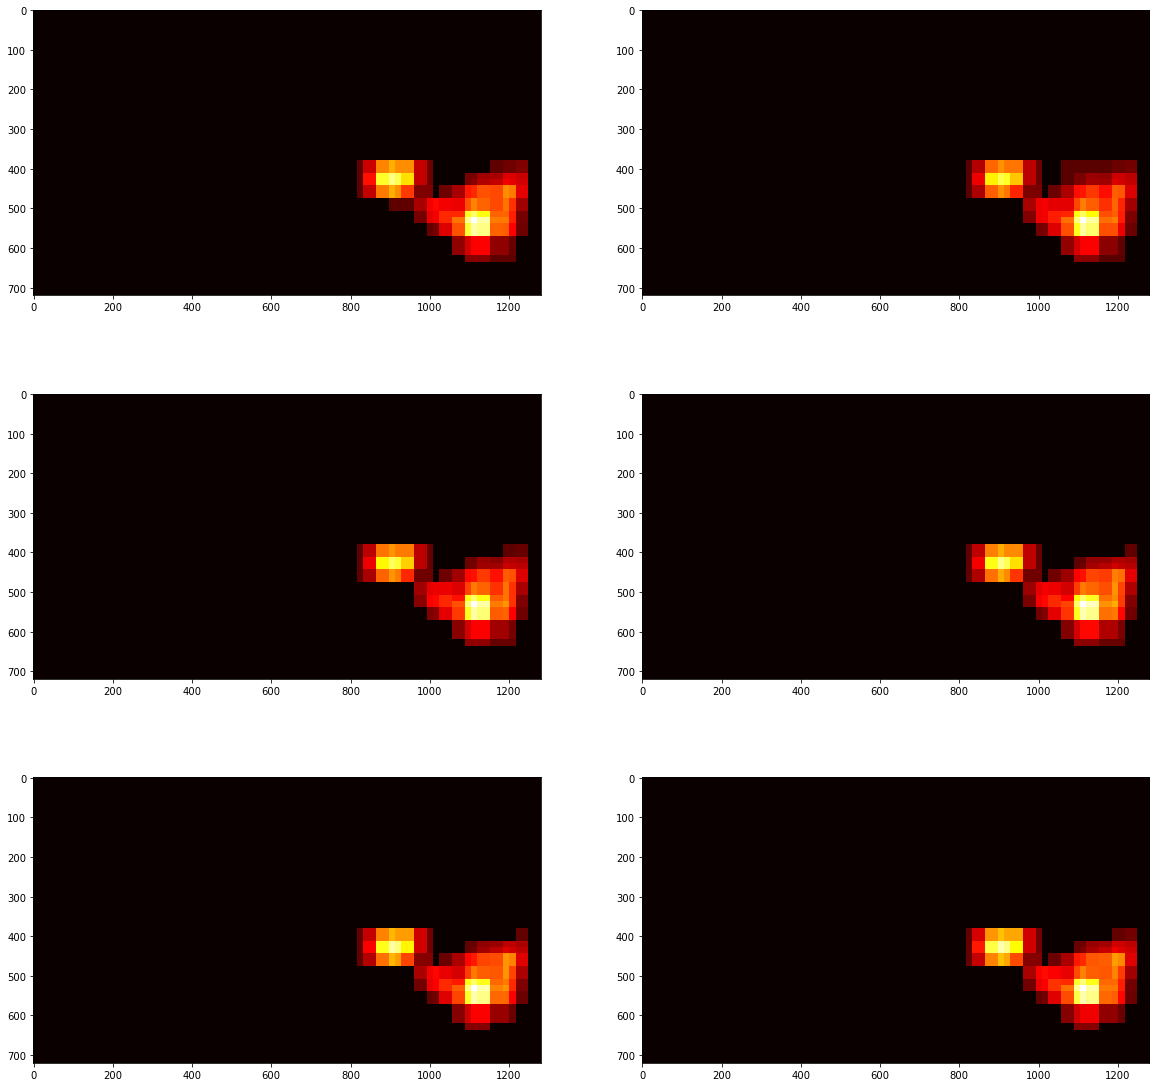

In [77]:
from helper.sliding_window import apply_threshold
from builtins import len # ups

f, axarr = plt.subplots(3, 2, figsize=(20,20))

for i in range(len(frames)):
    f = frames[i]
    heat = np.zeros_like(f[:, :, 0]).astype(np.float)
    found = search_windows(f, all_layers, clf, X_scaler, color_space="HLS", spatial_feat=False, hist_range=(0,256), cell_per_block=1)
    #draw_img = draw_boxes(np.copy(image), found)
    heat = add_heat(heat, found)
    heatmaps = push_pop(heatmaps, heat)
    av_h, l = avarage_heat(heatmaps)
    av_h = apply_threshold(av_h, 0.9)
    heatmap = np.clip(av_h, 0, 255)
    axarr[i//2, i%2].imshow(heatmap, cmap='hot', interpolation='nearest')

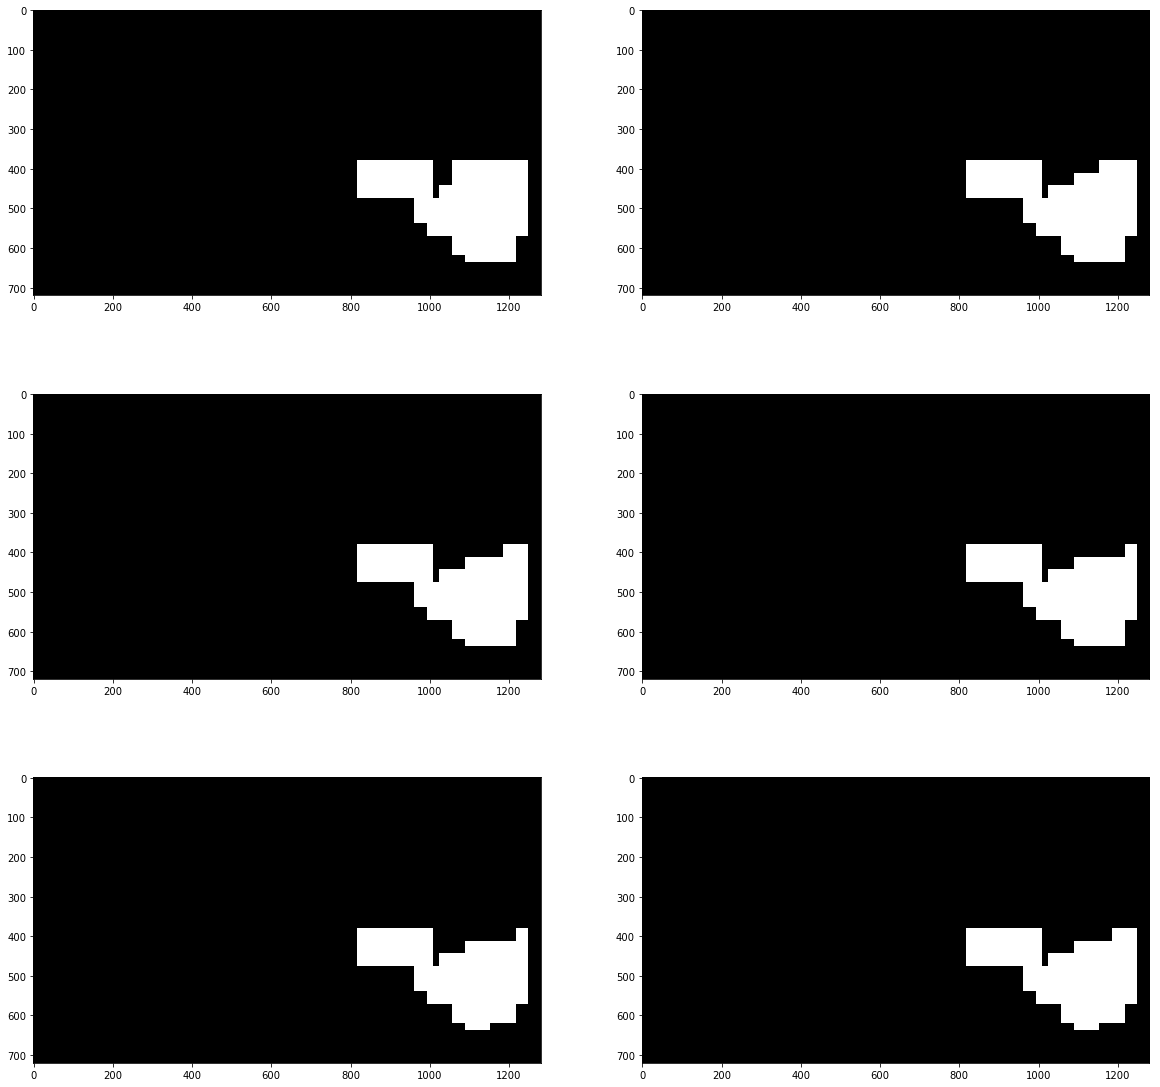

In [84]:
from scipy.ndimage.measurements import label
from helper.draw import draw_labeled_bboxes

f, axarr = plt.subplots(3, 2, figsize=(20,20))

for i in range(len(frames)):
    f = frames[i]
    heat = np.zeros_like(f[:, :, 0]).astype(np.float)
    found = search_windows(f, all_layers, clf, X_scaler, color_space="HLS", spatial_feat=False, hist_range=(0,256), cell_per_block=1)
    #draw_img = draw_boxes(np.copy(image), found)
    heat = add_heat(heat, found)
    heatmaps = push_pop(heatmaps, heat)
    av_h, l = avarage_heat(heatmaps)
    av_h = apply_threshold(av_h, 0.9)
    heatmap = np.clip(av_h, 0, 255)
    labels, numfeatures = label(heatmap)
    axarr[i//2, i%2].imshow(labels, cmap='gray')

#### final detection algorithm for 6 frames

The next cell shows the usage of the label method and the drawing of the bounding box. it also shows the problem that the label algorithm does not detect that the heatmap has two clusters as long as there is a connecting path between them. Raising the threshold would remove that problem, but also intruduce false negatives, which is worse

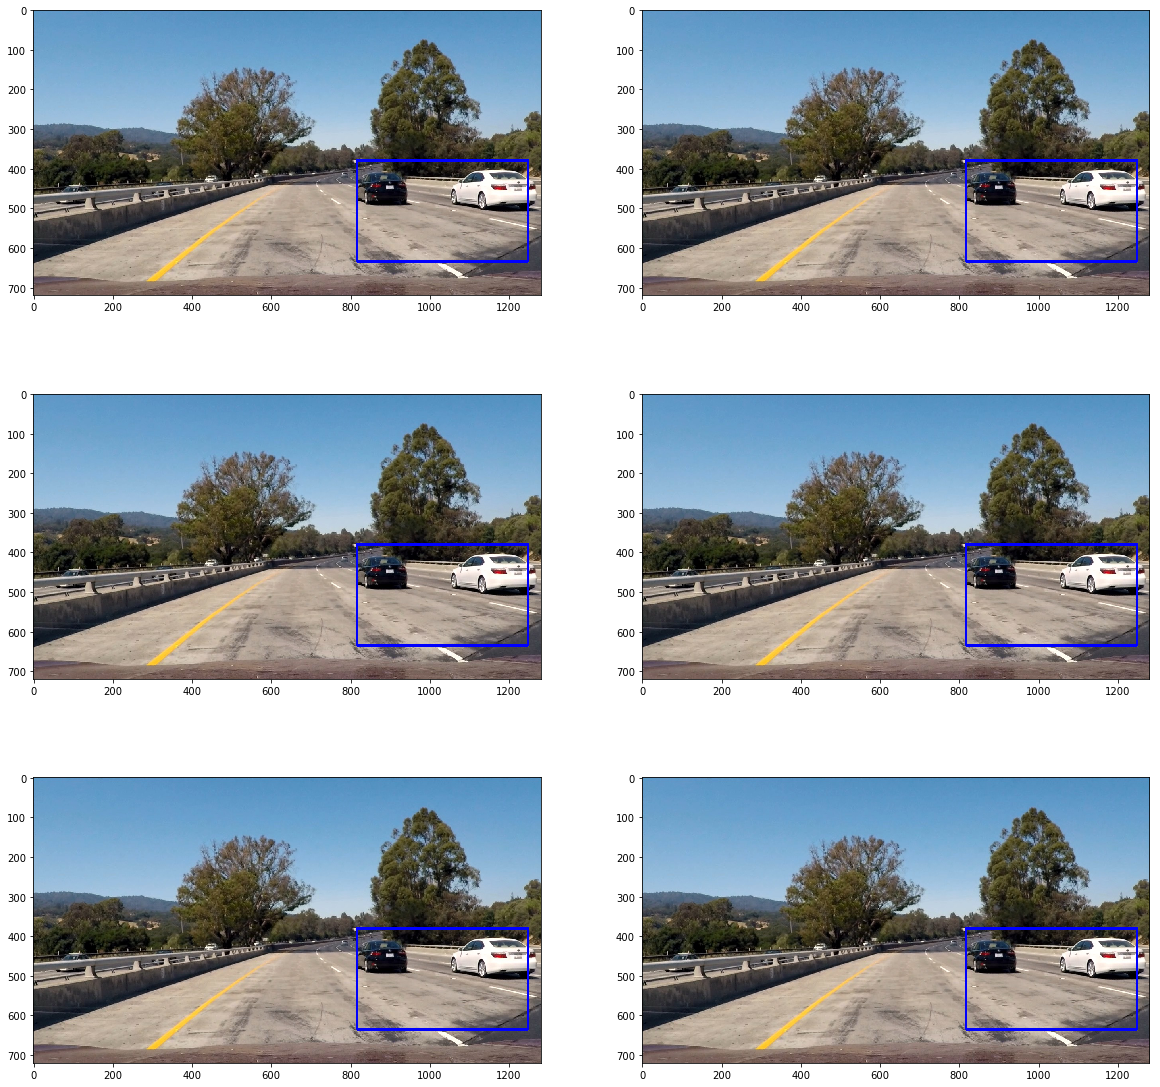

In [80]:
from scipy.ndimage.measurements import label
from helper.draw import draw_labeled_bboxes

f, axarr = plt.subplots(3, 2, figsize=(20,20))

for i in range(len(frames)):
    f = frames[i]
    heat = np.zeros_like(f[:, :, 0]).astype(np.float)
    found = search_windows(f, all_layers, clf, X_scaler, color_space="HLS", spatial_feat=False, hist_range=(0,256), cell_per_block=1)
    #draw_img = draw_boxes(np.copy(image), found)
    heat = add_heat(heat, found)
    heatmaps = push_pop(heatmaps, heat)
    av_h, l = avarage_heat(heatmaps)
    av_h = apply_threshold(av_h, 0.9)
    heatmap = np.clip(av_h, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    axarr[i//2, i%2].imshow(draw_img)
    